# Preliminaries

In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import colorcet as cc
import cartopy
import cartopy.crs as ccrs
import csv
import copy as cp
from scipy.stats import pearsonr, linregress
from scipy.signal import detrend
from scipy.io import loadmat
from matplotlib import cm, colors
from numba import njit, vectorize

In [3]:
#The interval of time we're looking at (1980 to 2019)
startyear = 1980
endyear = 2019
timeseries = np.arange(startyear, endyear + 1, 1) #yearly
timeseries_cont = np.arange(startyear, endyear + 1, 1/12) #monthly

#dictionary of months
monthsnum = np.arange(1,13,1)
monthsind = np.arange(0,12,1)
monthsstr = ['01','02','03','04','05','06','07','08','09','10','11','12']
monthsnam = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months = {1:'January',2:'February',3:'March',
          4:'April',5:'May',6:'June',7:'July',8:'August',
          9:'September',10:'October',11:'November',12:'December'}
names = ['NSIDC','Had2CIS','CANCM4','GEM_NEMO','COMBINED']
ensembles = np.arange(0,10,1)

#colours for graphing
col = ['navy','mediumblue','mediumslateblue','violet',
       'maroon','red','orange','gold','lime',
       'forestgreen','purple','darkturquoise']

#regions
PanAntarctic = np.array([0,360])
Weddell = np.array([300,20])
Indian = np.array([20,90])
WestPacific = np.array([90,160])
Ross = np.array([160,230])
Amundsen = np.array([230,300])

In [25]:
#function to calculate sea ice extent from sea ice fraction/concentration

@njit
def calculate_SIE (SIC_array, latdat, londat, region):
    '''
    SIC_array: 2D array of SIC values in the form of [lat][lon]
    lat: 1D array of all latitudes
    lon: 1D array of all longitudes
    '''
    
    #Will keep track of sea ice extent
    SIE_counter = 0

    #iterate over all latitudes and longitudes
    for i in range(len(latdat)): 
        for j in range(len(londat)):
            
            #only consider SOUTHERN hemisphere
            if latdat[i] < 0:
                
                #only consider a certain region
                if region[0] == Weddell[0]: #Weddell
                    if londat[j] >= region[0] or londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15 and SIC <= 1.: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
                            
                else: #all other regions
                    if londat[j] >= region[0] and londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15 and SIC <= 1.: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
    
    return SIE_counter/1e6

@njit
def calculate_SIE2 (SIC_array, latdat, londat, region):
    '''
    SIC_array: 2D array of SIC values in the form of [lat][lon]
    lat: 1D array of all latitudes
    lon: 1D array of all longitudes
    '''
    
    #Will keep track of sea ice extent
    SIE_counter = 0

    #iterate over all latitudes and longitudes
    for i in range(len(latdat)): 
        for j in range(len(londat)):
            
            #only consider SOUTHERN hemisphere
            if latdat[i] < 0:
                
                #only consider a certain region
                if region[0] == Weddell[0]: #Weddell
                    if londat[j] >= region[0] or londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15 and SIC <= 1.: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
                            
                else: #all other regions
                    if londat[j] >= region[0] and londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15 and SIC <= 1.: 
                            #SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            SIE_counter += areas[i][j] * 1e-6
                            #km^2 area of each 1x1deg grid cell near south pole
    
    return SIE_counter/1e6



#function to write data to .txt file

def writedat(yearlydata, filename, loc = "Region_PanAntarcticSIE"):
    '''
    yearlydata: (dictionary) the data to be written to file, in the form of a dictionary
    filename: (string) the name of the file, excluding the .txt
    '''

    #First, create file
    #x is to create file
    #w is to rewrite file. If file doesn't exist, create file.
    #a is to append to file. If file doesn't exist, create file.
    #r is to read file

    f = open(loc + "/" + str(filename) + ".txt", "w")

    #go year by year
    for year in yearlydata.keys():

        f.write(str(year) + " ")

        #SIE month by month for the above year
        for val in yearlydata[year]:

            f.write(str(val) + " ")

        f.write("\n")

    f.close()
    
    
    
#function to retrieve data from .txt file

def retrievedat (filename, loc = "Region_PanAntarcticSIE"):
    '''
    retrieve data from a .txt file in a specific format
    '''
    
    #dictionary full of data to be returned
    datadict = {}
    
    f = open(loc + "/" + str(filename) + ".txt", "r")
    
    #go line by line
    for line in f:
        
        #split line into an array
        line.replace('\n', '')
        linearray = line.split()
        
        year = np.int64(linearray[0])
        dat = linearray[1:]
        
        #convert nones to None and values to floats
        for i,d in enumerate(dat):
            if d == 'None':
                dat[i] = np.nan
            else:
                dat[i] = np.float64(d)
        
        datadict[year] = dat
    
    f.close()
    
    return datadict



#function to calculate average of array w/ None types

def average (array):
    
    net = 0
    count = 0
    
    for dat in array:
        if dat is not None and np.isnan(dat) == False:
            net += dat
            count += 1
            
    return net/count


#function to calculate average between CANCM4 and GEM_NEMO

def model_average (model1, model2, N=2):
    
    dictaveraged = {}
    
    for year in timeseries:
        
        dictaveraged[year]= [np.nan]*12
        
        for leadtime in monthsind:
            
            net = model1[year][leadtime] + model2[year][leadtime]
            ave = net/N #average
            
            dictaveraged[year][leadtime] = ave
    
    return dictaveraged


#function to retrieve all data pertaining to a specific month of the year

def DataForMonth (dataset, month, initmonth = 1):
    
    #Determine what type the input is in (e.g. array or dictionary)
    if type(dataset) == dict:
        dataset1D = Dict1D(dataset)
    else:
        dataset1D = dataset
            
    #Now pick out all the data corresponding to the specified month
    #e.g. if month = 1 and initmonth = 1, then it should pick out index 0, index 12, index 24, etc...
    
    index = (month - 1) - (initmonth - 1)
    datasetmonth = []

    if month < initmonth:
        index += 12
    while index < len(dataset1D):
        datasetmonth.append(dataset1D[index])
        index += 12 #jump forward 12 months
            
    return datasetmonth


#Put a dictionary of data into a 1D array

def Dict1D (dataset):
    
    #put all the data into a 1D array
    
    dataset1D = []
    for year in dataset.keys():
        for im in monthsind:
            dataset1D.append(dataset[year][im])
    
    return dataset1D


#Quickplot

def QuickPlot (datadict, colour = "Navy"):
    
    fig, axis = plt.subplots(1,1,figsize=(8,6))
    
    xaxis = timeseries_cont
    yaxis = Dict1D(datadict)
    
    axis.plot(xaxis, yaxis, color = colour)
    axis.grid()
    
    fig.tight_layout()

# Had2CIS observational data

In [29]:
#Retrieving HAD2CIS data

Had2CISdata = {}

#data will be a dictionary of the form 
#year:[jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
#let's set up this structure:

for year in timeseries:
    Had2CISdata[year]= [np.nan]*12

#open file

rawfile = "ObsData\had2cis_1x1_198001_202004_sicn.nc"
file = nc.Dataset(rawfile, 'r')

#will need these arrays

latitudes = file.variables['lat'][:]
longitudes = file.variables['lon'][:]
SICarray = file.variables['SICN'][:] #function of [time][lat][lon]

#collect data and put into dictionary

for year in timeseries:
    for month in monthsnum:
        
        #convert year and month into months since Jan 1980.
        timeindex = 12*(year - 1980) + (month - 1) # - 1?
    
        #retrieve associated SIC[lat][lon] matrix
        SIC = SICarray[timeindex] 
        
        #calculate SIE from SIC[lat][lon] matrix
        SIE_value = calculate_SIE(SIC, latitudes, longitudes, region=PanAntarctic)
        
        #append to dictionary
        Had2CISdata[year][month-1] = SIE_value

#close file
file.close()

# writedat(Had2CISdata, "Had2CISdat", loc="Region_AmundsenSIE")

<ipython-input-29-cf4006eaf997>:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = file.variables['lat'][:]
<ipython-input-29-cf4006eaf997>:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = file.variables['lon'][:]
<ipython-input-29-cf4006eaf997>:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`.

In [21]:
# rawfile = "ObsData\had2cis_1x1_sicn_gridarea.nc"
# file = nc.Dataset(rawfile, 'r')

# #will need these arrays

# areas = file.variables['cell_area'][:]
# file.close()

<ipython-input-21-b10357f1e1f2>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  areas = file.variables['cell_area'][:]


# CANCM4data

In [7]:
def getCANCM4data (initmonth, ensemble):

    #initmonth should be a string, e.g. '01'
    #ensemble should be a integer in [0,9]

    CANCM4data = {}

    #model data will again be a dictionary of the form
    #year:[leadtime0,leadtime1, ... , leadtime11]
    #for an initialization month of january, this looks like:
    #year:[jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
    #let's set up this structure:

    for year in timeseries:
        CANCM4data[year]= [np.nan]*12


    #Now to actually retrieve the data from the nc files
    #Go year by year this time, since that's how the 
    #data is organized.

    
    for year in timeseries:

        #open file

        startstr = "CANCM4Data\sic_monthly_CCCma-CanCM4_NEW_1x1_grid_i"
        endstr =  str(year) + initmonth + '01.nc' #specify year and initialization month
        rawfile = startstr + endstr

        file = nc.Dataset(rawfile, 'r')

        #(only need to get latitude and longitude once)
        if year == startyear:
            latitudes = file.variables['latitude'][:]
            longitudes = file.variables['longitude'][:]


        for month in monthsind:

            #get relevant data month by month,
            #then calculate the SIE for that month
            #and assign it to the appropriate spot
            #in CANSIPSdata dictionary.

            SIC = file.variables['sic'][:][month][ensemble]
            
            SIE_value = calculate_SIE(SIC, latitudes, longitudes, region=Amundsen)

            CANCM4data[year][month] = SIE_value



        #close file
        file.close()
        
    return CANCM4data

In [8]:
for ens in ensembles:
    print(ens)
    for im in monthsstr:
        
        SIEdata = getCANCM4data(im, ens)
        
        filename = "CANCM4datE" + str(ens) + im
        
        writedat(SIEdata, filename, loc = "Region_AmundsenSIE")

0


<ipython-input-7-1825106c6500>:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = file.variables['latitude'][:]
<ipython-input-7-1825106c6500>:36: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = file.variables['longitude'][:]
<ipython-input-7-1825106c6500>:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

1
2
3
4
5
6
7
8
9


# GEM NEMO data

In [9]:
def getGEMNEMOdata (initmonth, ensemble):

    #initmonth should be a string, e.g. '01'
    #ensemble should be a integer in [0,9]

    GEMNEMOdata = {}

    #model data will again be a dictionary of the form
    #year:[leadtime0,leadtime1, ... , leadtime11]
    #for an initialization month of january, this looks like:
    #year:[jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
    #let's set up this structure:

    for year in timeseries:
        GEMNEMOdata[year]= [np.nan]*12


    #Now to actually retrieve the data from the nc files
    #Go year by year this time, since that's how the 
    #data is organized.

    
    for year in timeseries:

        #open file

        startstr = "GEMNEMOData\sic_monthly_CCCma-GEM_NEMO_1x1_grid_i"
        endstr =  str(year) + initmonth + '01.nc' #specify year and initialization month
        rawfile = startstr + endstr

        file = nc.Dataset(rawfile, 'r')

        #(only need to get latitude and longitude once)
        if year == startyear:
            latitudes = file.variables['latitude'][:]
            longitudes = file.variables['longitude'][:]



        for month in monthsind:

            #get relevant data month by month,
            #then calculate the SIE for that month
            #and assign it to the appropriate spot
            #in data dictionary.

            SIC = file.variables['sic'][:][month][ensemble]

            SIE_value = calculate_SIE(SIC, latitudes, longitudes, region=Amundsen)

            GEMNEMOdata[year][month] = SIE_value



        #close file
        file.close()
        
    return GEMNEMOdata

In [10]:
# for ens in ensembles:
#     print(ens)
#     for im in monthsstr:
        
#         SIEdata = getGEMNEMOdata(im, ens)
        
#         filename = "GEMNEMOdatE" + str(ens) + im
        
#         writedat(SIEdata, filename, loc = "Region_AmundsenSIE")

0


<ipython-input-9-d9fde5d2dc21>:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = file.variables['latitude'][:]
<ipython-input-9-d9fde5d2dc21>:36: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = file.variables['longitude'][:]
<ipython-input-9-d9fde5d2dc21>:47: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

1
2
3
4
5
6
7
8
9


# Average Over Ensembles

In [11]:
# CANCM4

for i in monthsind:
    
    dataformonth = []
    im = monthsstr[i]
    
    #retrieve data for each ensemble
    for ens in ensembles:
        
        filename = 'CANCM4datE' + str(ens) + im
        
        dataformonth.append(retrievedat(filename, loc="Region_AmundsenSIE"))
    
    
    
    averages = {}
    for year in timeseries:
        averages[year] = [np.nan]*12
    
    #average over each ensemble
    for year in timeseries:
        for month in monthsind:
            vals = []
            for dats in dataformonth:
                vals.append(dats[year][month])
            averages[year][month] = average(vals)
                
        
        
    #write to file
#     writedat(averages, "CANCM4datAv" + im ,loc="Region_AmundsenSIE")
    

In [12]:
# GEMNEMO

for i in monthsind:
    
    dataformonth = []
    im = monthsstr[i]
    
    #retrieve data for each ensemble
    for ens in ensembles:
        
        filename = 'GEMNEMOdatE' + str(ens) + im
        
        dataformonth.append(retrievedat(filename, loc="Region_AmundsenSIE"))
    
    
    
    averages = {}
    for year in timeseries:
        averages[year] = [np.nan]*12
    
    #average over each ensemble
    for year in timeseries:
        for month in monthsind:
            vals = []
            for dats in dataformonth:
                vals.append(dats[year][month])
            averages[year][month] = average(vals)
                
        
        
    #write to file
#     writedat(averages, "GEMNEMOdatAv" + im ,loc="Region_AmundsenSIE")
    

# Average The Two Models for Each Ensemble

In [9]:
def model_average (model1, model2, N=2):
    
    dictaveraged = {}
    
    for year in timeseries:
        
        dictaveraged[year]= [np.nan]*12
        
        for leadtime in monthsind:
            
            net = model1[year][leadtime] + model2[year][leadtime]
            ave = net/N #average
            
            dictaveraged[year][leadtime] = ave
    
    return dictaveraged

In [14]:

#average gemnemo and cancm4 data
for im in monthsind:
    
    imstr = monthsstr[im]
    CANCM4dat = retrievedat("CANCM4datAv" + imstr, loc="Region_AmundsenSIE")
    GEMNEMOdat = retrievedat("GEMNEMOdatAv" + imstr, loc="Region_AmundsenSIE")
    
    averageddata = model_average(CANCM4dat,GEMNEMOdat)
    
    #write to file
    writedat(averageddata, "MODELAVEdatAv" + imstr, loc="Region_AmundsenSIE")

In [15]:
#Next, retrieve model data

CANCM4data = {}

#model data will again be a dictionary of the form 
#year:[jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
#let's set up this structure:

for year in timeseries:
    CANCM4data[year]= [None]*12
    
    
    
#Now to actually retrieve the data from the nc files
#Go year by year this time, since that's how the 
#data is organized. Ensemble chosen is 0.

ensemble = 0

for year in timeseries:
    for month in monthsnum:
        
        #open file
        
        startstr = "CANCM4Data\sic_monthly_CCCma-CanCM4_NEW_1x1_grid_i"
        endstr =  str(year) + str(monthsstr[month-1]) + '01.nc' #specify year and month
        rawfile = startstr + endstr

        file = nc.Dataset(rawfile, 'r')

        

        #get relevant data month by month,
        #then calculate the SIE for that month
        #and assign it to the appropriate spot
        #in CANSIPSdata dictionary.

        

        #(only need to get latitude and longitude once)
        if year == startyear:
            latitudes = file.variables['latitude'][:]
            longitudes = file.variables['longitude'][:]

        SIC = file.variables['sic'][:][0][ensemble] #month index is always 0 since we always take the initialized month

        SIE_value = calculate_SIE(SIC, latitudes, longitudes, region=Amundsen)

        CANCM4data[year][month-1] = SIE_value



        #close file
        file.close()

<ipython-input-15-a1f3398d6189>:42: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = file.variables['latitude'][:]
<ipython-input-15-a1f3398d6189>:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = file.variables['longitude'][:]
<ipython-input-15-a1f3398d6189>:45: DeprecationWarning: `np.bool` is a deprecated alias for the buil

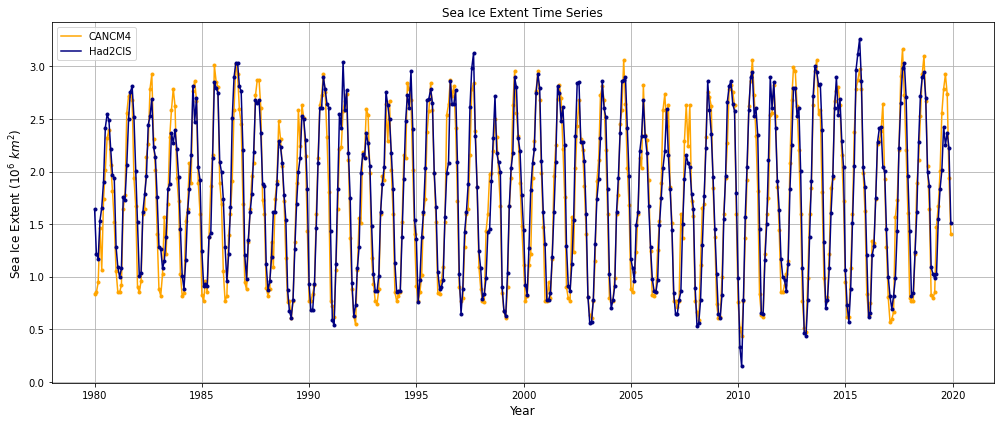

In [16]:
#Test plot of SIE over all time
#X axis will be timeseries_cont
#Y axis will be all CANSIPSV2 SIE data
xaxis = timeseries_cont
yaxis = Dict1D(retrievedat("Had2CISdat",loc="Region_AmundsenSIE"))
xaxis2 = timeseries_cont
yaxis2 = []

#get data for yaxis

for year in timeseries:
    for month in monthsnum:
        SIE_value = CANCM4data[year][month-1]
        yaxis2.append(SIE_value)
        
        
#Plot both on the same graph to compare!

fig, axis = plt.subplots(1,1,figsize=(14,6))

axis.set_title("Sea Ice Extent Time Series")
axis.plot(xaxis2, yaxis2,color='orange',label='CANCM4')
axis.plot(xaxis2, yaxis2,'.',color='orange')
axis.plot(xaxis, yaxis,color='navy',label='Had2CIS')
axis.plot(xaxis, yaxis,'.',color='navy')
axis.set_xlabel('Year',size=12)
axis.set_ylabel('Sea Ice Extent ($10^6\ km^2$)',size=12)
axis.legend()
axis.grid()

fig.tight_layout()

# CanESM

In [7]:
def getCANESMdata (im, ensemble, region_coords=PanAntarctic):

    #initmonth should be an integer in [1,12]
    #ensemble should be a integer in [0,9]

    CANESMdata = {}

    #model data will again be a dictionary of the form
    #year:[leadtime0,leadtime1, ... , leadtime11]
    #for an initialization month of january, this looks like:
    #year:[jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
    #let's set up this structure:

    for year in timeseries:
        CANESMdata[year]= [np.nan]*12

    #Now to actually retrieve the data from the nc files
    #open file
    
    if im == 1:
        rawfile = "CanESMData\sf_chfp3b_1x1_1980_m" + monthsstr[im-1] + "_2020_m" + monthsstr[(im-2)%12] + "_ens10_sicn.nc"
    else:
        rawfile = "CanESMData\sf_chfp3b_1x1_1980_m" + monthsstr[im-1] + "_2021_m" + monthsstr[(im-2)%12] + "_ens10_sicn.nc"
    file = nc.Dataset(rawfile, 'r')

    latitudes = file.variables['latitude'][:]
    longitudes = file.variables['longitude'][:]
    SIC = file.variables['SICN'][:]
    
    #go year by year
    for year in timeseries:

        #calculate index for lead-0 SIC for the given year
        ind = (year - 1980)*12

        #retrieve data
        
        for month in monthsind: #target month

            #get relevant data month by month,
            #then calculate the SIE for that month
            #and assign it to the appropriate spot
            #in data dictionary.
            
            SICv = SIC[ind+month][ensemble]
            SIE_value = calculate_SIE(SICv, latitudes, longitudes, region=region_coords)
            CANESMdata[year][month] = SIE_value

    #close file
    file.close()

    return CANESMdata

In [8]:
for ens in ensembles:
    print(ens)
    for im in monthsnum:
        
        SIEdata = getCANESMdata(im, ens, region_coords=PanAntarctic)
        
        filename = "CANESMdatE" + str(ens) + monthsstr[im-1] + "_NH"
        
        writedat(SIEdata, filename, loc = "Region_PanArcticSIE")

0


<ipython-input-7-982b80087bad>:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = file.variables['latitude'][:]
<ipython-input-7-982b80087bad>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = file.variables['longitude'][:]
<ipython-input-7-982b80087bad>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

1
2
3
4
5
6
7
8
9


In [9]:
# Average over ensembles

region = "Region_PanArcticSIE"
for i in monthsind:
    
    dataformonth = []
    im = monthsstr[i]
    
    #retrieve data for each ensemble
    for ens in ensembles:
        
        filename = 'CANESMdatE' + str(ens) + im + "_NH"
        
        dataformonth.append(retrievedat(filename, loc=region))
    
    
    
    averages = {}
    for year in timeseries:
        averages[year] = [np.nan]*12
    
    #average over each ensemble
    for year in timeseries:
        for month in monthsind:
            vals = []
            for dats in dataformonth:
                vals.append(dats[year][month])
            averages[year][month] = average(vals)
                
        
        
    #write to file
    writedat(averages, "CANESMdatAv" + im + "_NH",loc=region)

# CanESM5 nudged winds

In [5]:
rawfile = "CanESMnudgedwindsData\sicdata_1x1\siconc_SImon_CanESM5_01_historical_r1i1p1f1_gn_195001-202112_1x1.nc"
file = nc.Dataset(rawfile, 'r')
print(file.variables)
file.close()

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: time
    bounds: time_bnds
    units: days since 1850-01-01 0:0:0.0
    calendar: 365_day
    axis: T
unlimited dimensions: time
current shape = (864,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (864, 2)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (360,)
filling off, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (180,)
filling off, 'siconc': <class 'netCDF4._netCDF4.Variable'>
float32 siconc(time, lat, lon)
    standard_name: sea_ice_area_fraction
    long_name: Sea-Ice Area Percentage (Ocean Grid)
 

<ipython-input-5-b0e201381617>:3: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print(file.variables)


In [11]:
def getnudgedCANESMdata (run, region_coords=PanAntarctic):

    #run should be '01', '05', or '06'
    #valid years depends on run
    #'01' : 1950 - 2021, (will always return full time series regardless of specified year)
    #'05' : 1990 - 2020
    #'06' : 2000 - 2020

    CANESMdata = {}

    #model data will again be a dictionary of the form
    #year:[leadtime0,leadtime1, ... , leadtime11]
    #for an initialization month of january, this looks like:
    #year:[jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
    #let's set up this structure:

    if run == '01':
        start, end = [1950, 2021]
    elif run == '05':
        start, end = [1990, 2020]
    elif run == '06':
        start, end = [2000, 2020]
    timeseries_for_nudged = np.arange(start, end+1, 1)
    
    for year in timeseries_for_nudged:
        CANESMdata[year]= [np.nan]*12

    
    if run == '05' or run == '06':
        
        #go year by year and get data
        for year in timeseries_for_nudged:

            #retrieve data
            rawfile = "CanESMnudgedwindsData\sicdata_1x1\siconc_SImon_CanESM5_"+run+"_historical_r1i1p1f1_gn_"+str(year)+"01-"+str(year)+"12_1x1.nc"
            file = nc.Dataset(rawfile, 'r')
            if year == start:
                latitudes = np.array(file.variables['lat'][:])
                longitudes = np.array(file.variables['lon'][:])
            SIC = np.array(file.variables['siconc'][:])
            file.close()

            for month in monthsind: #target month

                #get relevant data month by month,
                #then calculate the SIE for that month
                #and assign it to the appropriate spot
                #in data dictionary.

                SICfield = np.array(SIC[month])/100
                SIE_value = calculate_SIE(SICfield, latitudes, longitudes, region=region_coords)
                CANESMdata[year][month] = SIE_value

    elif run =='01':
        
        rawfile = "CanESMnudgedwindsData\sicdata_1x1\siconc_SImon_CanESM5_"+run+"_historical_r1i1p1f1_gn_195001-202112_1x1.nc"
        file = nc.Dataset(rawfile, 'r')
        latitudes = np.array(file.variables['lat'][:])
        longitudes = np.array(file.variables['lon'][:])
        SIC = np.array(file.variables['siconc'][:])
        file.close()
        
        for year in timeseries_for_nudged:
            for month in monthsind:
                
                SICfield = np.array(SIC[12*(year - start)+month])/100
                SIE_value = calculate_SIE(SICfield, latitudes, longitudes, region=region_coords)
                CANESMdata[year][month] = SIE_value
        
    return CANESMdata

In [20]:
sector = "Amundsen"
sector_coords = Amundsen

SIEdata = getnudgedCANESMdata('06', region_coords=sector_coords)
filename = 'CANESMnudgedwindsdat_2000-2020'
writedat(SIEdata, filename, loc = "Region_"+sector+"SIE")

SIEdata = getnudgedCANESMdata('05', region_coords=sector_coords)
filename = 'CANESMnudgedwindsdat_1990-2020'
writedat(SIEdata, filename, loc = "Region_"+sector+"SIE")

SIEdata = getnudgedCANESMdata('01', region_coords=sector_coords)
filename = 'CANESMnudgedwindsdat_1950-2021'
writedat(SIEdata, filename, loc = "Region_"+sector+"SIE")

<ipython-input-11-e93a58fad1a3>:38: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = np.array(file.variables['lat'][:])
<ipython-input-11-e93a58fad1a3>:39: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = np.array(file.variables['lon'][:])
<ipython-input-11-e93a58fad1a3>:40: DeprecationWarning: `np.bool` is a deprecated alias for

# Strong Nudged CanESM5

In [5]:
filename = "CanESMnudgedwindsData/sicdata_1x1/siconc_SImon_fullnudge_CanESM5_01_historical_r1i1p1f1_gn_195001-202112_1x1.nc"
file = nc.Dataset(filename,'r')
SICfield_nud = np.array(file.variables['siconc'][:]) / 100.
lon_nud = file.variables['lon'][:]
lat_nud = file.variables['lat'][:]
file.close()

<ipython-input-5-36d7fdca7720>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfield_nud = np.array(file.variables['siconc'][:]) / 100.
<ipython-input-5-36d7fdca7720>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon_nud = file.variables['lon'][:]
<ipython-input-5-36d7fdca7720>:5: DeprecationWarning: `np.bool` is a deprecated alias for the b

In [7]:
def getstrongnudgedCANESMdata (region_coords=PanAntarctic):

    CANESMdata = {}

    #model data will again be a dictionary of the form
    #year:[leadtime0,leadtime1, ... , leadtime11]
    #for an initialization month of january, this looks like:
    #year:[jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
    #let's set up this structure:

    start, end = [1950, 2021]
    timeseries_for_nudged = np.arange(start, end+1, 1)
    
    for year in timeseries_for_nudged:
        CANESMdata[year]= [np.nan]*12
        
    rawfile = "CanESMnudgedwindsData/sicdata_1x1/siconc_SImon_fullnudge_CanESM5_01_historical_r1i1p1f1_gn_195001-202112_1x1.nc"
    file = nc.Dataset(rawfile, 'r')
    latitudes = np.array(file.variables['lat'][:])
    longitudes = np.array(file.variables['lon'][:])
    SIC = np.array(file.variables['siconc'][:])
    file.close()

    for year in timeseries_for_nudged:
        for month in monthsind:

            SICfield = np.array(SIC[12*(year - start)+month])/100
            SIE_value = calculate_SIE(SICfield, latitudes, longitudes, region=region_coords)
            CANESMdata[year][month] = SIE_value
        
    return CANESMdata

In [14]:
sector = "Amundsen"
sector_coords = Amundsen

SIEdata = getstrongnudgedCANESMdata(region_coords=sector_coords)
filename = 'CANESMstrongnudgedwindsdat_1950-2021'
writedat(SIEdata, filename, loc = "Region_"+sector+"SIE")

<ipython-input-7-b78e98119411>:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = np.array(file.variables['lat'][:])
<ipython-input-7-b78e98119411>:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = np.array(file.variables['lon'][:])
<ipython-input-7-b78e98119411>:21: DeprecationWarning: `np.bool` is a deprecated alias for th

# Latitude-Constrained CanCM4i

In [17]:
dividing_lat = -65

@njit
def calculate_SIE_south (SIC_array, latdat, londat, region):
    '''
    SIC_array: 2D array of SIC values in the form of [lat][lon]
    lat: 1D array of all latitudes
    lon: 1D array of all longitudes
    '''
    
    #Will keep track of sea ice extent
    SIE_counter = 0

    #iterate over all latitudes and longitudes
    for i in range(len(latdat)): 
        for j in range(len(londat)):
            
            #only consider SOUTHERN hemisphere
            if latdat[i] < dividing_lat:
                
                #only consider a certain region
                if region[0] == Weddell[0]: #Weddell
                    if londat[j] >= region[0] or londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15 and SIC <= 1.: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
                            
                else: #all other regions
                    if londat[j] >= region[0] and londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15 and SIC <= 1.: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
    
    return SIE_counter/1e6

@njit
def calculate_SIE_north (SIC_array, latdat, londat, region):
    '''
    SIC_array: 2D array of SIC values in the form of [lat][lon]
    lat: 1D array of all latitudes
    lon: 1D array of all longitudes
    '''
    
    #Will keep track of sea ice extent
    SIE_counter = 0

    #iterate over all latitudes and longitudes
    for i in range(len(latdat)): 
        for j in range(len(londat)):
            
            #only consider SOUTHERN hemisphere
            if latdat[i] > dividing_lat and latdat[i] < 0:
                
                #only consider a certain region
                if region[0] == Weddell[0]: #Weddell
                    if londat[j] >= region[0] or londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15 and SIC <= 1.: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
                            
                else: #all other regions
                    if londat[j] >= region[0] and londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15 and SIC <= 1.: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
    
    return SIE_counter/1e6

In [18]:
#Retrieving HAD2CIS data

Had2CISdata = {}

#data will be a dictionary of the form 
#year:[jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
#let's set up this structure:

for year in timeseries:
    Had2CISdata[year]= [np.nan]*12

#open file

rawfile = "ObsData\had2cis_1x1_198001_202004_sicn.nc"
file = nc.Dataset(rawfile, 'r')

#will need these arrays

latitudes = file.variables['lat'][:]
longitudes = file.variables['lon'][:]
SICarray = file.variables['SICN'][:] #function of [time][lat][lon]

#collect data and put into dictionary

for year in timeseries:
    for month in monthsnum:
        
        #convert year and month into months since Jan 1980.
        timeindex = 12*(year - 1980) + (month - 1) 
    
        #retrieve associated SIC[lat][lon] matrix
        SIC = SICarray[timeindex] 
        
        #calculate SIE from SIC[lat][lon] matrix
        SIE_value = calculate_SIE_north(SIC, latitudes, longitudes, region=Weddell)
        
        #append to dictionary
        Had2CISdata[year][month-1] = SIE_value

#close file
file.close()

writedat(Had2CISdata, "Had2CISdat", loc="Region_WeddellNorthSIE")

<ipython-input-18-aaec043d7033>:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = file.variables['lat'][:]
<ipython-input-18-aaec043d7033>:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = file.variables['lon'][:]
<ipython-input-18-aaec043d7033>:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`.

In [19]:
#Retrieving HAD2CIS data

Had2CISdata = {}

#data will be a dictionary of the form 
#year:[jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
#let's set up this structure:

for year in timeseries:
    Had2CISdata[year]= [np.nan]*12

#open file

rawfile = "ObsData\had2cis_1x1_198001_202004_sicn.nc"
file = nc.Dataset(rawfile, 'r')

#will need these arrays

latitudes = file.variables['lat'][:]
longitudes = file.variables['lon'][:]
SICarray = file.variables['SICN'][:] #function of [time][lat][lon]

#collect data and put into dictionary

for year in timeseries:
    for month in monthsnum:
        
        #convert year and month into months since Jan 1980.
        timeindex = 12*(year - 1980) + (month - 1) 
    
        #retrieve associated SIC[lat][lon] matrix
        SIC = SICarray[timeindex] 
        
        #calculate SIE from SIC[lat][lon] matrix
        SIE_value = calculate_SIE_south(SIC, latitudes, longitudes, region=Weddell)
        
        #append to dictionary
        Had2CISdata[year][month-1] = SIE_value

#close file
file.close()

writedat(Had2CISdata, "Had2CISdat", loc="Region_WeddellSouthSIE")

<ipython-input-19-0e84b1aef655>:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = file.variables['lat'][:]
<ipython-input-19-0e84b1aef655>:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = file.variables['lon'][:]
<ipython-input-19-0e84b1aef655>:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`.

In [26]:
# for year in timeseries:
#     for initmonth in monthsstr:
        
#         #open file
#         startstr = "CANCM4Data\sic_monthly_CCCma-CanCM4_NEW_1x1_grid_i"
#         endstr =  str(year) + initmonth + '01.nc' #specify year and initialization month
#         rawfile = startstr + endstr
#         file = nc.Dataset(rawfile, 'r')
        
#         #save lon/lat data
#         if year == startyear:
#             latitudes = np.array(file.variables['latitude'][:])
#             longitudes = np.array(file.variables['longitude'][:])
#             np.save("CANCM4Data\lat.npy",latitudes)
#             np.save("CANCM4Data\lon.npy",longitudes)
            
#         #save SIC data
#         for ensemble in range(10):
#             sics = file.variables['sic'][:][month][ensemble]
#             np.save("CANCM4Data\CANCM4SICdatE" + str(ensemble) +)

<ipython-input-26-7274586eafc2>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = np.array(file.variables['latitude'][:])
<ipython-input-26-7274586eafc2>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = np.array(file.variables['longitude'][:])


In [20]:
def getCANCM4data_north (initmonth, ensemble):

    #initmonth should be a string, e.g. '01'
    #ensemble should be a integer in [0,9]

    CANCM4data = {}

    #model data will again be a dictionary of the form
    #year:[leadtime0,leadtime1, ... , leadtime11]
    #for an initialization month of january, this looks like:
    #year:[jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
    #let's set up this structure:

    for year in timeseries:
        CANCM4data[year]= [np.nan]*12


    #Now to actually retrieve the data from the nc files
    #Go year by year this time, since that's how the 
    #data is organized.

    
    for year in timeseries:

        #open file

        startstr = "CANCM4Data\sic_monthly_CCCma-CanCM4_NEW_1x1_grid_i"
        endstr =  str(year) + initmonth + '01.nc' #specify year and initialization month
        rawfile = startstr + endstr

        file = nc.Dataset(rawfile, 'r')

        #(only need to get latitude and longitude once)
        if year == startyear:
            latitudes = file.variables['latitude'][:]
            longitudes = file.variables['longitude'][:]


        for month in monthsind:

            #get relevant data month by month,
            #then calculate the SIE for that month
            #and assign it to the appropriate spot
            #in CANSIPSdata dictionary.

            SIC = file.variables['sic'][:][month][ensemble]
            
            SIE_value = calculate_SIE_north(SIC, latitudes, longitudes, region=Weddell)

            CANCM4data[year][month] = SIE_value

        #close file
        file.close()
        
    return CANCM4data

def getCANCM4data_south (initmonth, ensemble):

    #initmonth should be a string, e.g. '01'
    #ensemble should be a integer in [0,9]

    CANCM4data = {}

    #model data will again be a dictionary of the form
    #year:[leadtime0,leadtime1, ... , leadtime11]
    #for an initialization month of january, this looks like:
    #year:[jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
    #let's set up this structure:

    for year in timeseries:
        CANCM4data[year]= [np.nan]*12


    #Now to actually retrieve the data from the nc files
    #Go year by year this time, since that's how the 
    #data is organized.

    
    for year in timeseries:

        #open file

        startstr = "CANCM4Data\sic_monthly_CCCma-CanCM4_NEW_1x1_grid_i"
        endstr =  str(year) + initmonth + '01.nc' #specify year and initialization month
        rawfile = startstr + endstr

        file = nc.Dataset(rawfile, 'r')

        #(only need to get latitude and longitude once)
        if year == startyear:
            latitudes = file.variables['latitude'][:]
            longitudes = file.variables['longitude'][:]


        for month in monthsind:

            #get relevant data month by month,
            #then calculate the SIE for that month
            #and assign it to the appropriate spot
            #in CANSIPSdata dictionary.

            SIC = file.variables['sic'][:][month][ensemble]
            
            SIE_value = calculate_SIE_south(SIC, latitudes, longitudes, region=Weddell)

            CANCM4data[year][month] = SIE_value

        #close file
        file.close()
        
    return CANCM4data

In [27]:
# for ens in ensembles:
#     print(ens)
#     for im in monthsstr:
        
#         SIEdata_north = getCANCM4data_north(im, ens)
#         #SIEdata_south = getCANCM4data_south(im, ens)
        
#         filename = "CANCM4datE" + str(ens) + im
        
#         writedat(SIEdata_north, filename, loc = "Region_WeddellNorthSIE")
#         #writedat(SIEdata_south, filename, loc = "Region_WeddellSouthSIE")

0


<ipython-input-20-f14243e0f740>:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = file.variables['latitude'][:]
<ipython-input-20-f14243e0f740>:36: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = file.variables['longitude'][:]
<ipython-input-20-f14243e0f740>:46: DeprecationWarning: `np.bool` is a deprecated alias for the buil

1
2
3
4
5
6
7
8
9


In [28]:
# for ens in ensembles:
#     print(ens)
#     for im in monthsstr:
        
#         #SIEdata_north = getCANCM4data_north(im, ens)
#         SIEdata_south = getCANCM4data_south(im, ens)
        
#         filename = "CANCM4datE" + str(ens) + im
        
#         #writedat(SIEdata_north, filename, loc = "Region_WeddellNorthSIE")
#         writedat(SIEdata_south, filename, loc = "Region_WeddellSouthSIE")

<ipython-input-20-f14243e0f740>:91: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = file.variables['latitude'][:]
<ipython-input-20-f14243e0f740>:92: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = file.variables['longitude'][:]
<ipython-input-20-f14243e0f740>:102: DeprecationWarning: `np.bool` is a deprecated alias for the bui

0


<ipython-input-20-f14243e0f740>:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SIC = file.variables['sic'][:][month][ensemble]
<ipython-input-20-f14243e0f740>:91: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = file.variables['latitude'][:]
<ipython-input-20-f14243e0f740>:92: DeprecationWarning: `np.bool` is a deprecated alias for the

1
2
3
4
5
6
7
8
9


In [29]:
def getGEMNEMOdata_north (initmonth, ensemble):

    #initmonth should be a string, e.g. '01'
    #ensemble should be a integer in [0,9]

    GEMNEMOdata = {}

    #model data will again be a dictionary of the form
    #year:[leadtime0,leadtime1, ... , leadtime11]
    #for an initialization month of january, this looks like:
    #year:[jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
    #let's set up this structure:

    for year in timeseries:
        GEMNEMOdata[year]= [np.nan]*12


    #Now to actually retrieve the data from the nc files
    #Go year by year this time, since that's how the 
    #data is organized.

    
    for year in timeseries:

        #open file

        startstr = "GEMNEMOData\sic_monthly_CCCma-GEM_NEMO_1x1_grid_i"
        endstr =  str(year) + initmonth + '01.nc' #specify year and initialization month
        rawfile = startstr + endstr

        file = nc.Dataset(rawfile, 'r')

        #(only need to get latitude and longitude once)
        if year == startyear:
            latitudes = file.variables['latitude'][:]
            longitudes = file.variables['longitude'][:]



        for month in monthsind:

            #get relevant data month by month,
            #then calculate the SIE for that month
            #and assign it to the appropriate spot
            #in data dictionary.

            SIC = file.variables['sic'][:][month][ensemble]

            SIE_value = calculate_SIE_north(SIC, latitudes, longitudes, region=Weddell)

            GEMNEMOdata[year][month] = SIE_value



        #close file
        file.close()
        
    return GEMNEMOdata

def getGEMNEMOdata_south (initmonth, ensemble):

    #initmonth should be a string, e.g. '01'
    #ensemble should be a integer in [0,9]

    GEMNEMOdata = {}

    #model data will again be a dictionary of the form
    #year:[leadtime0,leadtime1, ... , leadtime11]
    #for an initialization month of january, this looks like:
    #year:[jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
    #let's set up this structure:

    for year in timeseries:
        GEMNEMOdata[year]= [np.nan]*12


    #Now to actually retrieve the data from the nc files
    #Go year by year this time, since that's how the 
    #data is organized.

    
    for year in timeseries:

        #open file

        startstr = "GEMNEMOData\sic_monthly_CCCma-GEM_NEMO_1x1_grid_i"
        endstr =  str(year) + initmonth + '01.nc' #specify year and initialization month
        rawfile = startstr + endstr

        file = nc.Dataset(rawfile, 'r')

        #(only need to get latitude and longitude once)
        if year == startyear:
            latitudes = file.variables['latitude'][:]
            longitudes = file.variables['longitude'][:]



        for month in monthsind:

            #get relevant data month by month,
            #then calculate the SIE for that month
            #and assign it to the appropriate spot
            #in data dictionary.

            SIC = file.variables['sic'][:][month][ensemble]

            SIE_value = calculate_SIE_south(SIC, latitudes, longitudes, region=Weddell)

            GEMNEMOdata[year][month] = SIE_value



        #close file
        file.close()
        
    return GEMNEMOdata

In [30]:
for ens in ensembles:
    print(ens)
    for im in monthsstr:
        
        #SIEdata_north = getGEMNEMOdata_north(im, ens)
        SIEdata_south = getGEMNEMOdata_south(im, ens)
        
        filename = "GEMNEMOdatE" + str(ens) + im
        
        #writedat(SIEdata_north, filename, loc = "Region_WeddellNorthSIE")
        writedat(SIEdata_south, filename, loc = "Region_WeddellSouthSIE")

0


<ipython-input-29-5ce3c0fd21e5>:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = file.variables['latitude'][:]
<ipython-input-29-5ce3c0fd21e5>:95: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = file.variables['longitude'][:]
<ipython-input-29-5ce3c0fd21e5>:106: DeprecationWarning: `np.bool` is a deprecated alias for the bui

1
2
3
4
5
6
7
8
9


In [31]:
for ens in ensembles:
    print(ens)
    for im in monthsstr:
        
        SIEdata_north = getGEMNEMOdata_north(im, ens)
        #SIEdata_south = getGEMNEMOdata_south(im, ens)
        
        filename = "GEMNEMOdatE" + str(ens) + im
        
        writedat(SIEdata_north, filename, loc = "Region_WeddellNorthSIE")
        #writedat(SIEdata_south, filename, loc = "Region_WeddellSouthSIE")

0


<ipython-input-29-5ce3c0fd21e5>:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = file.variables['latitude'][:]
<ipython-input-29-5ce3c0fd21e5>:36: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  longitudes = file.variables['longitude'][:]
<ipython-input-29-5ce3c0fd21e5>:47: DeprecationWarning: `np.bool` is a deprecated alias for the buil

1
2
3
4
5
6
7
8
9


In [8]:
# Averages

for i in monthsind:
    
    dataformonth = []
    im = monthsstr[i]
    
    #retrieve data for each ensemble
    for ens in ensembles:
        
        filename = 'CANCM4datE' + str(ens) + im
        
        dataformonth.append(retrievedat(filename, loc="Region_WeddellNorthSIE"))
    
    
    
    averages = {}
    for year in timeseries:
        averages[year] = [np.nan]*12
    
    #average over each ensemble
    for year in timeseries:
        for month in monthsind:
            vals = []
            for dats in dataformonth:
                vals.append(dats[year][month])
            averages[year][month] = average(vals)
                
        
        
    #write to file
    writedat(averages, "CANCM4datAv" + im ,loc="Region_WeddellNorthSIE")

for i in monthsind:
    
    dataformonth = []
    im = monthsstr[i]
    
    #retrieve data for each ensemble
    for ens in ensembles:
        
        filename = 'CANCM4datE' + str(ens) + im
        
        dataformonth.append(retrievedat(filename, loc="Region_WeddellSouthSIE"))
    
    
    
    averages = {}
    for year in timeseries:
        averages[year] = [np.nan]*12
    
    #average over each ensemble
    for year in timeseries:
        for month in monthsind:
            vals = []
            for dats in dataformonth:
                vals.append(dats[year][month])
            averages[year][month] = average(vals)
                
        
        
    #write to file
    writedat(averages, "CANCM4datAv" + im ,loc="Region_WeddellSouthSIE")
    
for i in monthsind:
    
    dataformonth = []
    im = monthsstr[i]
    
    #retrieve data for each ensemble
    for ens in ensembles:
        
        filename = 'GEMNEMOdatE' + str(ens) + im
        
        dataformonth.append(retrievedat(filename, loc="Region_WeddellNorthSIE"))
    
    
    
    averages = {}
    for year in timeseries:
        averages[year] = [np.nan]*12
    
    #average over each ensemble
    for year in timeseries:
        for month in monthsind:
            vals = []
            for dats in dataformonth:
                vals.append(dats[year][month])
            averages[year][month] = average(vals)
                
        
        
    #write to file
    writedat(averages, "GEMNEMOdatAv" + im ,loc="Region_WeddellNorthSIE")

for i in monthsind:
    
    dataformonth = []
    im = monthsstr[i]
    
    #retrieve data for each ensemble
    for ens in ensembles:
        
        filename = 'GEMNEMOdatE' + str(ens) + im
        
        dataformonth.append(retrievedat(filename, loc="Region_WeddellSouthSIE"))
    
    
    
    averages = {}
    for year in timeseries:
        averages[year] = [np.nan]*12
    
    #average over each ensemble
    for year in timeseries:
        for month in monthsind:
            vals = []
            for dats in dataformonth:
                vals.append(dats[year][month])
            averages[year][month] = average(vals)
                
        
        
    #write to file
    writedat(averages, "GEMNEMOdatAv" + im ,loc="Region_WeddellSouthSIE")

In [10]:
#average gemnemo and cancm4 data
for im in monthsind:
    
    imstr = monthsstr[im]
    CANCM4dat = retrievedat("CANCM4datAv" + imstr, loc="Region_WeddellSouthSIE")
    GEMNEMOdat = retrievedat("GEMNEMOdatAv" + imstr, loc="Region_WeddellSouthSIE")
    
    averageddata = model_average(CANCM4dat,GEMNEMOdat)
    
    #write to file
    writedat(averageddata, "MODELAVEdatAv" + imstr, loc="Region_WeddellSouthSIE")
    
for im in monthsind:
    
    imstr = monthsstr[im]
    CANCM4dat = retrievedat("CANCM4datAv" + imstr, loc="Region_WeddellNorthSIE")
    GEMNEMOdat = retrievedat("GEMNEMOdatAv" + imstr, loc="Region_WeddellNorthSIE")
    
    averageddata = model_average(CANCM4dat,GEMNEMOdat)
    
    #write to file
    writedat(averageddata, "MODELAVEdatAv" + imstr, loc="Region_WeddellNorthSIE")